In [1]:
import numpy as np
import pandas as pd
import os
import joblib

In [2]:
random_state = 100

if not os.path.isdir("model_dumps"):
    os.makedirs("model_dumps")

## Data Loading

Set the filename here

In [3]:
CSV_FILENAME = "final_eda_features.csv" #<-- update csv name
df_features = pd.read_csv(CSV_FILENAME)
df_features.head()

,Unnamed: 0.1,Unnamed: 0,path,updated_source_h,updated_source_w,face_index,used_mask,R_BIN_mask_0,R_BIN_mask_1,R_BIN_mask_2,...,SOBEL_BIN_bbox_14,SOBEL_BIN_bbox_15,SOBEL_BIN_bbox_16,SOBEL_BIN_bbox_17,SOBEL_BIN_bbox_18,SOBEL_BIN_bbox_19,x,y,w,h
0,0,0,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,683,1024,75,True,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.824519,0.508413,0.019231,0.021635
1,1,2,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,768,1024,23,True,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.284856,0.522837,0.012019,0.016827
2,2,4,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,768,1024,1,True,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.918269,0.612981,0.009615,0.014423
3,3,5,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,683,1024,2,True,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.602163,0.334135,0.055288,0.072115
4,4,6,C:\Users\jayba\Documents\GitHub\THS-ST1\images...,632,1024,25,True,0.0,0.166667,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.335337,0.486779,0.016827,0.021635


```
df_features = df_features.drop(columns = ['Unnamed: 0', 'path', 'source_w', 'source_h', 'face_index'])
df_features = df_features.loc[df_features["e_bbox_yf"] < 3, :]
print(df_features.columns)
```

Change string types to numeric types

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
encoder = LabelEncoder()
categorical_columns = df_features.select_dtypes(include=[bool, object]).columns
encoded_columns = df_features[categorical_columns].apply(encoder.fit_transform)
encoded_columns

,path,used_mask,source_file
0,4300,1,10169
1,4301,1,10170
2,4302,1,10171
3,4303,1,10172
4,4304,1,10173
...,...,...,...
21592,9706,1,1030
21593,9707,1,1031
21594,9708,1,1032
21595,9709,1,1033


In [6]:
df_encoded_features = df_features.copy()
df_encoded_features[categorical_columns] = encoded_columns
df_encoded_features

,Unnamed: 0.1,Unnamed: 0,path,updated_source_h,updated_source_w,face_index,used_mask,R_BIN_mask_0,R_BIN_mask_1,R_BIN_mask_2,...,SOBEL_BIN_bbox_14,SOBEL_BIN_bbox_15,SOBEL_BIN_bbox_16,SOBEL_BIN_bbox_17,SOBEL_BIN_bbox_18,SOBEL_BIN_bbox_19,x,y,w,h
0,0,0,4300,683,1024,75,1,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.824519,0.508413,0.019231,0.021635
1,1,2,4301,768,1024,23,1,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.284856,0.522837,0.012019,0.016827
2,2,4,4302,768,1024,1,1,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.918269,0.612981,0.009615,0.014423
3,3,5,4303,683,1024,2,1,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.602163,0.334135,0.055288,0.072115
4,4,6,4304,632,1024,25,1,0.00000,0.166667,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.335337,0.486779,0.016827,0.021635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,21597,27313,9706,233,191,0,1,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.519231,0.574519,0.408654,0.663462
21593,21598,27314,9707,500,366,0,1,0.00000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.518029,0.554087,0.367788,0.531250
21594,21599,27315,9708,337,286,0,1,0.22905,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.509615,0.450721,0.432692,0.588942
21595,21600,27316,9709,235,215,0,1,0.00000,0.000000,0.106667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.474760,0.486779,0.362981,0.507212


Split into X and Y

In [7]:
feat_regions = ["bbox", "mask"]

color_channels = {
    "RGB": ("R_BIN_", "G_BIN_", "B_BIN_"),
    "HSV": ("H_HSV_BIN_", "S_HSV_BIN_", "V_HSV_BIN_"),
    "HSL": ("H_HSL_BIN_", "S_HSL_BIN_", "L_HSL_BIN_"),
    "LAB": ("L_LAB_BIN_", "A_LAB_BIN_", "B_LAB_BIN_"),
    "YCBCR": ("Y_BIN_", "CR_BIN_", "CB_BIN_"),
}

#labels = {"bbox": "e_bbox_yf", "mask": "e_face_yf"}
labels = {"mask": "e_bbox_yf", "bbox": "e_face_yf"} #<-- inverted

In [8]:
def get_features_and_label(color_space, region):
    features = ["w", "h", "x", "y"]
    for color_channel in color_channels[color_space]: 
        features += [color_channel + region + "_" + str(i) for i in range(26)]
    features += ["LBP_BIN_" + region + "_" + str(i) for i in range(26)]
    features += ["SOBELX_BIN_" + region + "_" + str(i) for i in range(20)]
    features += ["SOBELY_BIN_" + region + "_" + str(i) for i in range(20)]
    features += ["SOBEL_BIN_" + region + "_" + str(i) for i in range(20)]
    return features, labels[region]

In [9]:
from sklearn.model_selection import train_test_split
CHOSEN_COLOR_SPACE = "HSV" #<-- pick a colorspace
CHOSEN_REGION = "bbox"

features, label = get_features_and_label(CHOSEN_COLOR_SPACE, CHOSEN_REGION)

X_features =  df_encoded_features.loc[:,  features]
y_features = df_encoded_features.loc[:, label].values #<-- pick label

X_train, X_test, y_train, y_test = train_test_split(X_features, y_features, test_size = 0.2, random_state=random_state)

In [10]:
X_features.columns.tolist()

['w',
 'h',
 'x',
 'y',
 'H_HSV_BIN_bbox_0',
 'H_HSV_BIN_bbox_1',
 'H_HSV_BIN_bbox_2',
 'H_HSV_BIN_bbox_3',
 'H_HSV_BIN_bbox_4',
 'H_HSV_BIN_bbox_5',
 'H_HSV_BIN_bbox_6',
 'H_HSV_BIN_bbox_7',
 'H_HSV_BIN_bbox_8',
 'H_HSV_BIN_bbox_9',
 'H_HSV_BIN_bbox_10',
 'H_HSV_BIN_bbox_11',
 'H_HSV_BIN_bbox_12',
 'H_HSV_BIN_bbox_13',
 'H_HSV_BIN_bbox_14',
 'H_HSV_BIN_bbox_15',
 'H_HSV_BIN_bbox_16',
 'H_HSV_BIN_bbox_17',
 'H_HSV_BIN_bbox_18',
 'H_HSV_BIN_bbox_19',
 'H_HSV_BIN_bbox_20',
 'H_HSV_BIN_bbox_21',
 'H_HSV_BIN_bbox_22',
 'H_HSV_BIN_bbox_23',
 'H_HSV_BIN_bbox_24',
 'H_HSV_BIN_bbox_25',
 'S_HSV_BIN_bbox_0',
 'S_HSV_BIN_bbox_1',
 'S_HSV_BIN_bbox_2',
 'S_HSV_BIN_bbox_3',
 'S_HSV_BIN_bbox_4',
 'S_HSV_BIN_bbox_5',
 'S_HSV_BIN_bbox_6',
 'S_HSV_BIN_bbox_7',
 'S_HSV_BIN_bbox_8',
 'S_HSV_BIN_bbox_9',
 'S_HSV_BIN_bbox_10',
 'S_HSV_BIN_bbox_11',
 'S_HSV_BIN_bbox_12',
 'S_HSV_BIN_bbox_13',
 'S_HSV_BIN_bbox_14',
 'S_HSV_BIN_bbox_15',
 'S_HSV_BIN_bbox_16',
 'S_HSV_BIN_bbox_17',
 'S_HSV_BIN_bbox_18',
 'S_HS

In [11]:
features

['w',
 'h',
 'x',
 'y',
 'H_HSV_BIN_bbox_0',
 'H_HSV_BIN_bbox_1',
 'H_HSV_BIN_bbox_2',
 'H_HSV_BIN_bbox_3',
 'H_HSV_BIN_bbox_4',
 'H_HSV_BIN_bbox_5',
 'H_HSV_BIN_bbox_6',
 'H_HSV_BIN_bbox_7',
 'H_HSV_BIN_bbox_8',
 'H_HSV_BIN_bbox_9',
 'H_HSV_BIN_bbox_10',
 'H_HSV_BIN_bbox_11',
 'H_HSV_BIN_bbox_12',
 'H_HSV_BIN_bbox_13',
 'H_HSV_BIN_bbox_14',
 'H_HSV_BIN_bbox_15',
 'H_HSV_BIN_bbox_16',
 'H_HSV_BIN_bbox_17',
 'H_HSV_BIN_bbox_18',
 'H_HSV_BIN_bbox_19',
 'H_HSV_BIN_bbox_20',
 'H_HSV_BIN_bbox_21',
 'H_HSV_BIN_bbox_22',
 'H_HSV_BIN_bbox_23',
 'H_HSV_BIN_bbox_24',
 'H_HSV_BIN_bbox_25',
 'S_HSV_BIN_bbox_0',
 'S_HSV_BIN_bbox_1',
 'S_HSV_BIN_bbox_2',
 'S_HSV_BIN_bbox_3',
 'S_HSV_BIN_bbox_4',
 'S_HSV_BIN_bbox_5',
 'S_HSV_BIN_bbox_6',
 'S_HSV_BIN_bbox_7',
 'S_HSV_BIN_bbox_8',
 'S_HSV_BIN_bbox_9',
 'S_HSV_BIN_bbox_10',
 'S_HSV_BIN_bbox_11',
 'S_HSV_BIN_bbox_12',
 'S_HSV_BIN_bbox_13',
 'S_HSV_BIN_bbox_14',
 'S_HSV_BIN_bbox_15',
 'S_HSV_BIN_bbox_16',
 'S_HSV_BIN_bbox_17',
 'S_HSV_BIN_bbox_18',
 'S_HS

## Load Model

In [12]:
# TODO: LOAD MODEL HERE
from sklearn.base import clone as clone_model

model = joblib.load("model_dumps/mpr_tunedfs_bo_HSV_bbox.pkl")
model = clone_model(model.best_estimator_.named_steps["mpr"])
model.fit(X_train, y_train)

E:\Program Files\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
E:\Program Files\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
E:\Program Files\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
E:\Program Files\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
E:\Program Files\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
E:\Program Files\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid

MLPRegressor(alpha=0.0006077414104241369, beta_1=0.75,
             beta_2=0.9174938922030286, early_stopping=True,
             hidden_layer_sizes=(113, 75, 50), learning_rate='invscaling',
             learning_rate_init=0.0005, max_fun=10000, max_iter=1000,
             momentum=0.75, n_iter_no_change=15, random_state=100,
             shuffle=False, validation_fraction=0.15)

In [13]:
model

MLPRegressor(alpha=0.0006077414104241369, beta_1=0.75,
             beta_2=0.9174938922030286, early_stopping=True,
             hidden_layer_sizes=(113, 75, 50), learning_rate='invscaling',
             learning_rate_init=0.0005, max_fun=10000, max_iter=1000,
             momentum=0.75, n_iter_no_change=15, random_state=100,
             shuffle=False, validation_fraction=0.15)

## SHAP

In [14]:
import shap

In [15]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)
# shap_values = explainer.shap_values(X_test)

Permutation explainer: 4321it [12:32,  5.69it/s]                                                                       


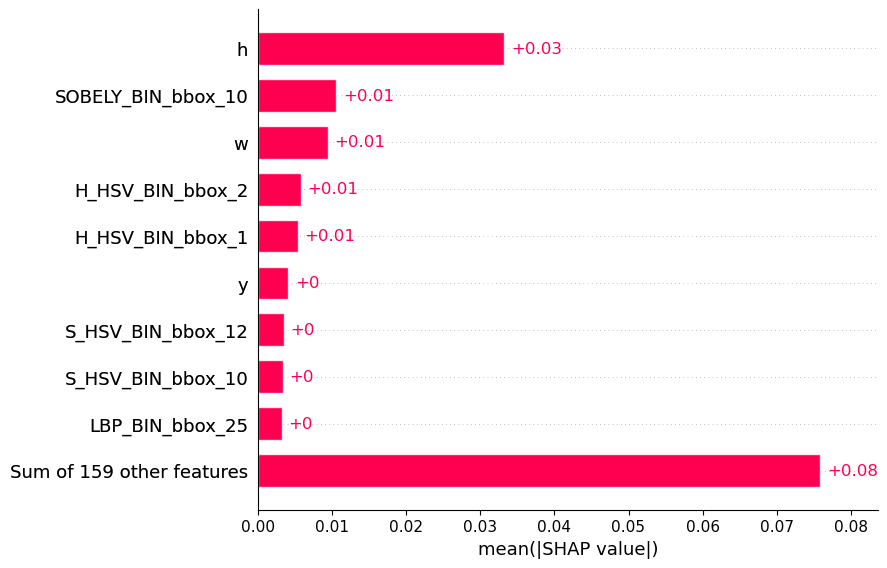

In [16]:
shap.plots.bar(shap_values)

## Grouped Shap Values

In [17]:
def group_shap_features(color_space, region):
    yolo = ["w", "h", "x", "y"]
    color = []
    for color_channel in color_channels[color_space]: 
        color.append([color_channel + region + "_" + str(i) for i in range(26)])
    lbp = ["LBP_BIN_" + region + "_" + str(i) for i in range(26)]
    sobel_x = ["SOBELX_BIN_" + region + "_" + str(i) for i in range(20)]
    sobel_y = ["SOBELY_BIN_" + region + "_" + str(i) for i in range(20)]
    sobel = ["SOBEL_BIN_" + region + "_" + str(i) for i in range(20)]
    return (yolo, *color, lbp, sobel_x, sobel_y, sobel)

In [35]:
groups = {}
groups['XYWH'] = []
groups['Hue'] = []
groups['Saturation'] = []
groups['Value'] = []
groups['LBP'] = []
groups['Sobel_X'] = []
groups['Sobel_Y'] = []
groups['Sobel'] = []

groups['XYWH'], groups['Hue'], groups['Saturation'], groups['Value'], groups['LBP'], groups['Sobel_X'], groups['Sobel_Y'], groups['Sobel'] = group_shap_features(CHOSEN_COLOR_SPACE, CHOSEN_REGION)
groups['X'] = groups['XYWH'][0]
groups['Y'] = groups['XYWH'][1]
groups['W'] = groups['XYWH'][2]
groups['H'] = groups['XYWH'][3]
groups.pop('XYWH')

['w', 'h', 'x', 'y']

In [36]:
groups

{'Hue': ['H_HSV_BIN_bbox_0',
  'H_HSV_BIN_bbox_1',
  'H_HSV_BIN_bbox_2',
  'H_HSV_BIN_bbox_3',
  'H_HSV_BIN_bbox_4',
  'H_HSV_BIN_bbox_5',
  'H_HSV_BIN_bbox_6',
  'H_HSV_BIN_bbox_7',
  'H_HSV_BIN_bbox_8',
  'H_HSV_BIN_bbox_9',
  'H_HSV_BIN_bbox_10',
  'H_HSV_BIN_bbox_11',
  'H_HSV_BIN_bbox_12',
  'H_HSV_BIN_bbox_13',
  'H_HSV_BIN_bbox_14',
  'H_HSV_BIN_bbox_15',
  'H_HSV_BIN_bbox_16',
  'H_HSV_BIN_bbox_17',
  'H_HSV_BIN_bbox_18',
  'H_HSV_BIN_bbox_19',
  'H_HSV_BIN_bbox_20',
  'H_HSV_BIN_bbox_21',
  'H_HSV_BIN_bbox_22',
  'H_HSV_BIN_bbox_23',
  'H_HSV_BIN_bbox_24',
  'H_HSV_BIN_bbox_25'],
 'Saturation': ['S_HSV_BIN_bbox_0',
  'S_HSV_BIN_bbox_1',
  'S_HSV_BIN_bbox_2',
  'S_HSV_BIN_bbox_3',
  'S_HSV_BIN_bbox_4',
  'S_HSV_BIN_bbox_5',
  'S_HSV_BIN_bbox_6',
  'S_HSV_BIN_bbox_7',
  'S_HSV_BIN_bbox_8',
  'S_HSV_BIN_bbox_9',
  'S_HSV_BIN_bbox_10',
  'S_HSV_BIN_bbox_11',
  'S_HSV_BIN_bbox_12',
  'S_HSV_BIN_bbox_13',
  'S_HSV_BIN_bbox_14',
  'S_HSV_BIN_bbox_15',
  'S_HSV_BIN_bbox_16',
  'S_HSV_

In [37]:
df_data = pd.DataFrame()
df_values = pd.DataFrame()
for dict_idx, dict_item in groups.items():
    counter = 0
    for item in dict_item:
        counter += 1
        idx = X_test.columns.get_loc(item)
#         print(item, idx)
        if counter == 1:
            df_data[dict_idx] = shap_values.data[:, idx]
            df_values[dict_idx] = shap_values.values[:, idx]
        else:
            df_data[dict_idx] += shap_values.data[:, idx]
            df_values[dict_idx] += shap_values.values[:, idx]

In [38]:
aggregates = shap.Explanation(df_values.to_numpy(), base_values=shap_values.base_values, data=df_data.to_numpy(), feature_names=df_data.columns.tolist())

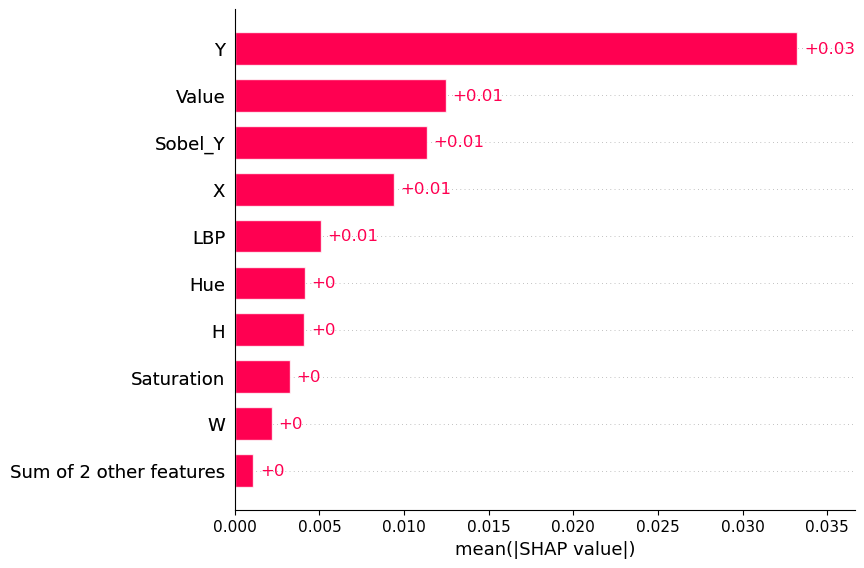

In [39]:
shap.plots.bar(aggregates)

## Directional Impact

In [41]:
for x, y in enumerate(shap_values.feature_names):
    print(x, y)

0 w
1 h
2 x
3 y
4 H_HSV_BIN_bbox_0
5 H_HSV_BIN_bbox_1
6 H_HSV_BIN_bbox_2
7 H_HSV_BIN_bbox_3
8 H_HSV_BIN_bbox_4
9 H_HSV_BIN_bbox_5
10 H_HSV_BIN_bbox_6
11 H_HSV_BIN_bbox_7
12 H_HSV_BIN_bbox_8
13 H_HSV_BIN_bbox_9
14 H_HSV_BIN_bbox_10
15 H_HSV_BIN_bbox_11
16 H_HSV_BIN_bbox_12
17 H_HSV_BIN_bbox_13
18 H_HSV_BIN_bbox_14
19 H_HSV_BIN_bbox_15
20 H_HSV_BIN_bbox_16
21 H_HSV_BIN_bbox_17
22 H_HSV_BIN_bbox_18
23 H_HSV_BIN_bbox_19
24 H_HSV_BIN_bbox_20
25 H_HSV_BIN_bbox_21
26 H_HSV_BIN_bbox_22
27 H_HSV_BIN_bbox_23
28 H_HSV_BIN_bbox_24
29 H_HSV_BIN_bbox_25
30 S_HSV_BIN_bbox_0
31 S_HSV_BIN_bbox_1
32 S_HSV_BIN_bbox_2
33 S_HSV_BIN_bbox_3
34 S_HSV_BIN_bbox_4
35 S_HSV_BIN_bbox_5
36 S_HSV_BIN_bbox_6
37 S_HSV_BIN_bbox_7
38 S_HSV_BIN_bbox_8
39 S_HSV_BIN_bbox_9
40 S_HSV_BIN_bbox_10
41 S_HSV_BIN_bbox_11
42 S_HSV_BIN_bbox_12
43 S_HSV_BIN_bbox_13
44 S_HSV_BIN_bbox_14
45 S_HSV_BIN_bbox_15
46 S_HSV_BIN_bbox_16
47 S_HSV_BIN_bbox_17
48 S_HSV_BIN_bbox_18
49 S_HSV_BIN_bbox_19
50 S_HSV_BIN_bbox_20
51 S_HSV_BIN_bbox_21
52

In [48]:
feat_names = {}
feat_names['XYWH'] = ['X', 'Y', 'W', 'H']
feat_names['Hue'] = []
feat_names['Saturation'] = []
feat_names['Value'] = []
feat_names['LBP'] = []
feat_names['Sobel_X'] = []
feat_names['Sobel_Y'] = []
feat_names['Sobel'] = []

for i in range(26):
    feat_names['Hue'].append( 'Hue ' + str(i) )
    feat_names['Saturation'].append( 'Saturation ' + str(i) )
    feat_names['Value'].append('Value ' + str(i) )
    feat_names['LBP'].append('LBP ' + str(i) )

for i in range(20):
    feat_names['Sobel_X'].append('Sobel X ' + str(i) )
    feat_names['Sobel_Y'].append('Sobel Y ' + str(i) )
    feat_names['Sobel'].append('Sobel ' + str(i) )

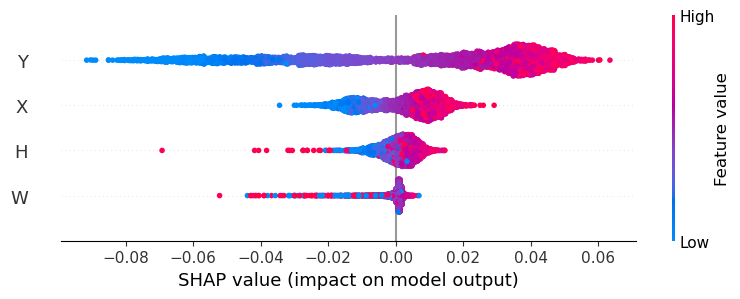

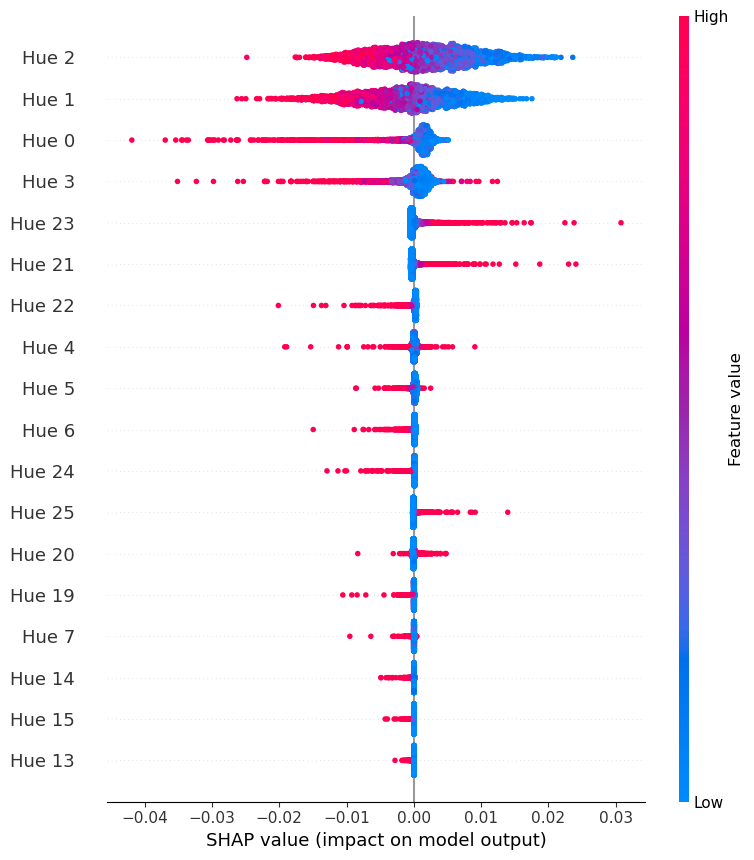

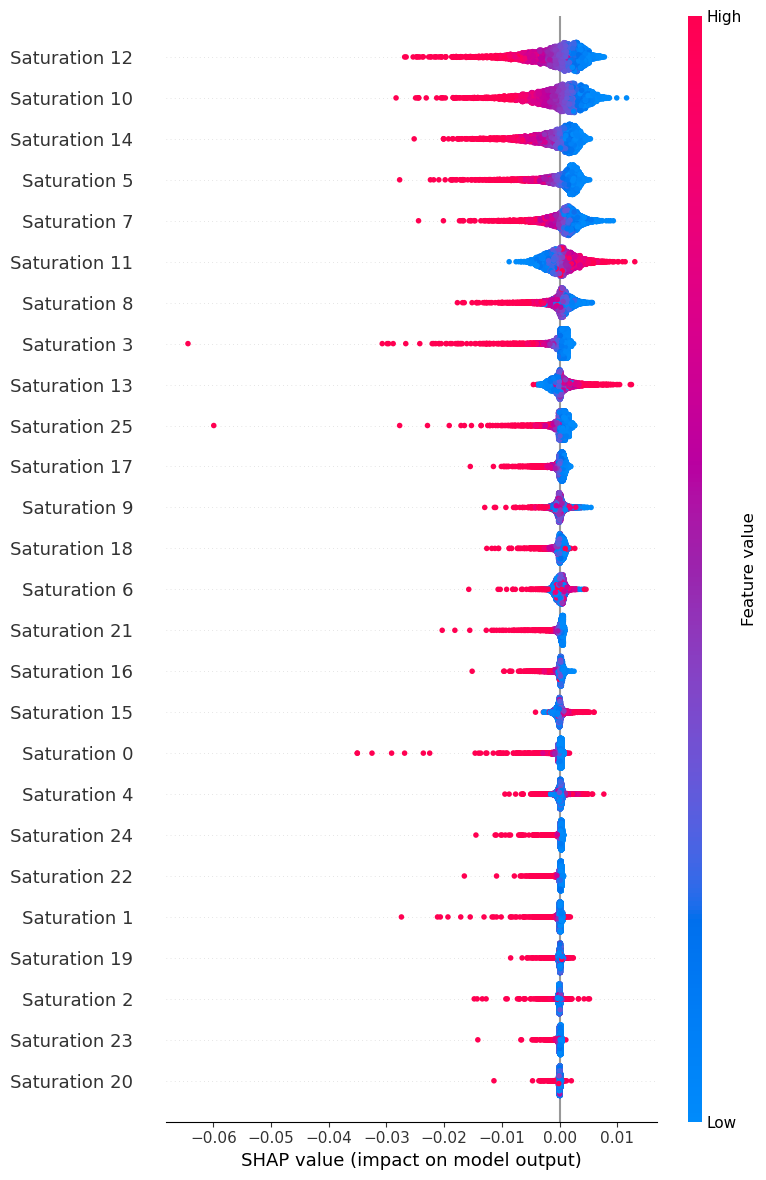

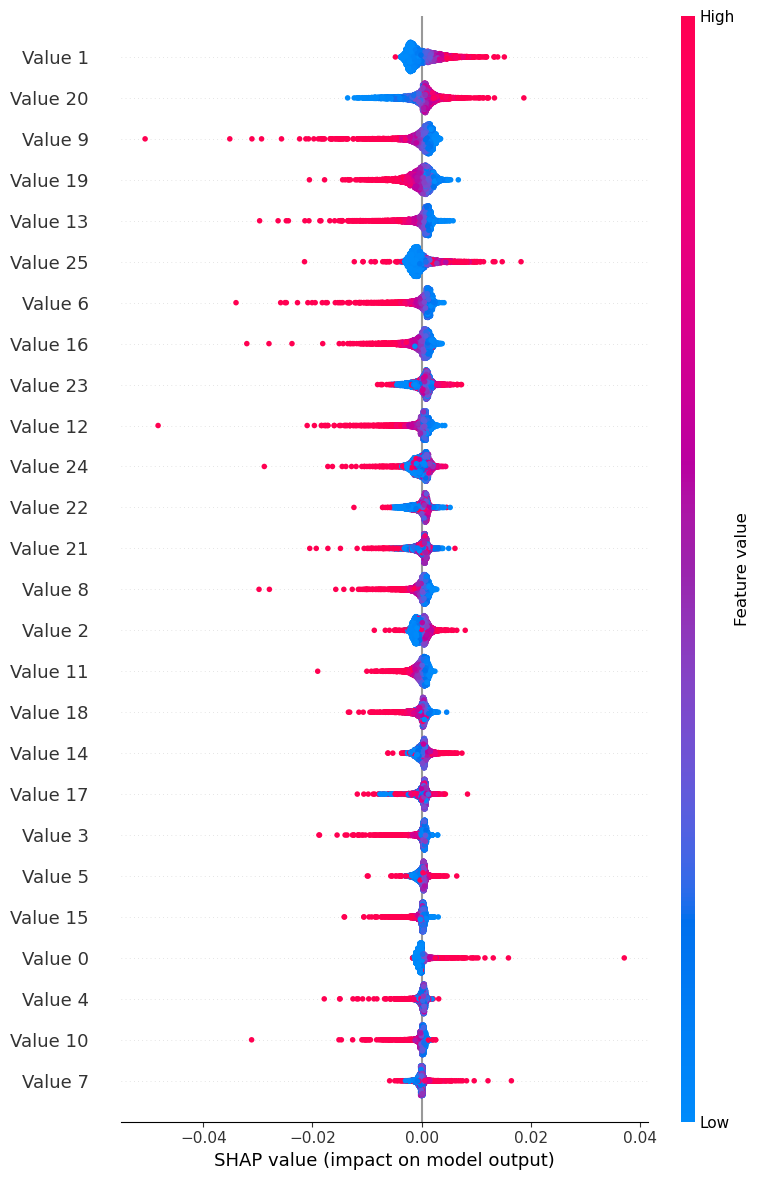

In [ ]:
shap.summary_plot(shap_values[:, 0:4], feature_names=feat_names['XYWH'], max_display=18)
shap.summary_plot(shap_values[:, 4:30], feature_names=feat_names['Hue'], max_display=18)
shap.summary_plot(shap_values[:, 30:56], feature_names=feat_names['Saturation'], max_display=26)
shap.summary_plot(shap_values[:, 56:82], feature_names=feat_names['Value'], max_display=26)
shap.summary_plot(shap_values[:, 82:108], feature_names=feat_names['LBP'], max_display=26)
shap.summary_plot(shap_values[:, 108:128], feature_names=feat_names['Sobel_X'], max_display=20)
shap.summary_plot(shap_values[:, 128:148], feature_names=feat_names['Sobel_Y'], max_display=20)
shap.summary_plot(shap_values[:, 148:168], feature_names=feat_names['Sobel'], max_display=20)

In [66]:
shap_values[:, 108:128].shape

(4320, 20)

IndexError: list index out of range

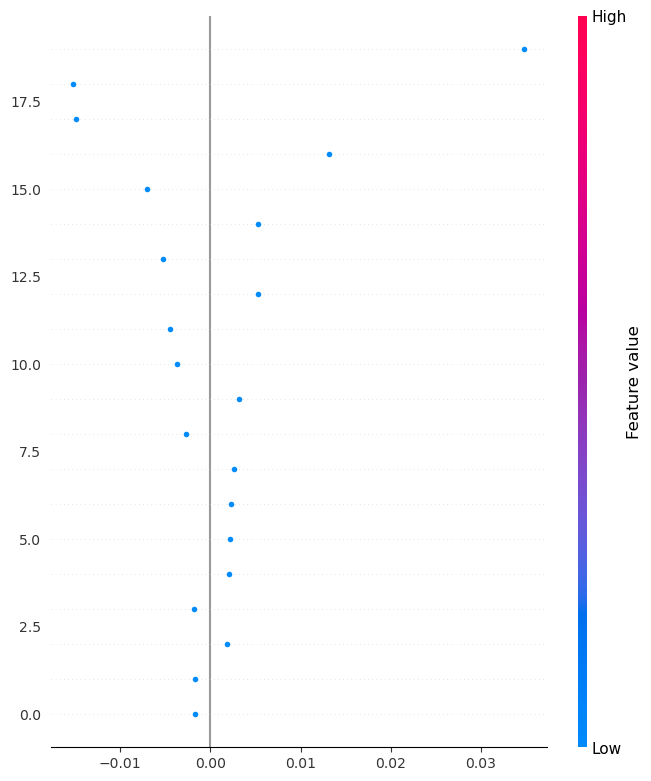